In [1]:
from SimPEG import *
from SimPEG.EM.Static import DC
import numpy as np
%pylab inline

/Users/andrewpare/anaconda/envs/py27_1608/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
cs =25.
hx = [(cs,7,-1.3), (cs,21), (cs,7,1.3)]
hy = [(cs,7,-1.3), (cs,21), (cs,7,1.3)]
hz = [(cs,7,-1.3), (cs,20)]

In [3]:
mesh = Mesh.TensorMesh([hx,hy,hz],'CCN')

In [4]:
blk1 = Utils.ModelBuilder.getIndicesBlock(np.r_[-50,75,-50], np.r_[75,-50,-150], mesh.gridCC)
sighalf = 1e-3
sigma = np.ones(mesh.nC)*sighalf
sigma[blk1] = 1e-1
sigmahomo = np.ones(mesh.nC)*sighalf

(<matplotlib.collections.QuadMesh at 0x10c5601d0>,
 <matplotlib.lines.Line2D at 0x10c560750>)

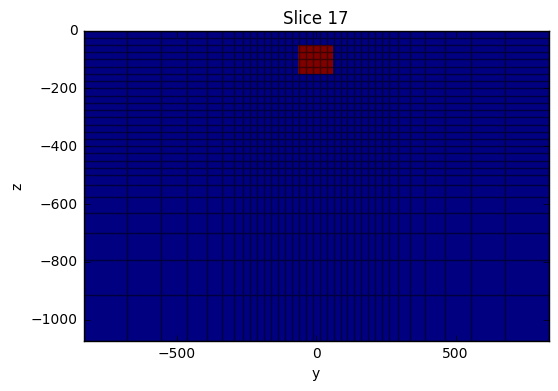

In [5]:
mesh.plotSlice(sigma, normal='X', grid=True)

In [6]:
xtemp = np.linspace(-150, 150, 21)
ytemp = np.linspace(-150, 150, 21)
xyz_rxM = Utils.ndgrid(xtemp-10., ytemp, np.r_[0.])
xyz_rxN = Utils.ndgrid(xtemp+10., ytemp, np.r_[0.])
xyz_rxP = Utils.ndgrid(xtemp, ytemp, np.r_[0.])

In [7]:
#plt.plot(xyz_rxP[:,0], xyz_rxP[:,1], 'k.')
plt.plot(xyz_rxM[:,0], xyz_rxM[:,1], 'r.')
plt.plot(xyz_rxN[:,0], xyz_rxN[:,1], 'g.')

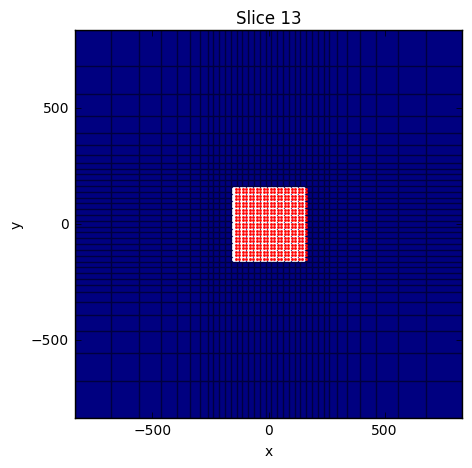

In [8]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
mesh.plotSlice(sigma, grid=True, ax = ax)
ax.plot(xyz_rxP[:,0],xyz_rxP[:,1], 'w.')
ax.plot(xyz_rxN[:,0],xyz_rxN[:,1], 'r.', ms = 3)

In [9]:
rx = DC.Rx.Dipole(xyz_rxM, xyz_rxN)
tx = DC.Src.Dipole([rx], np.array([-200,0,-12.5]), np.array([+200, 0, -12.5]))

In [10]:
txList = []
txList.append(DC.Src.Dipole([rx], np.array([-200, 0, -12.5]),np.array([+200, 0, -12.5])))
#txList.append(DC.Src.Dipole([rx], np.array([-200, 0, -12.5]),np.array([+100, 0, -12.5])))

In [11]:
txList

In [12]:
survey = DC.Survey(txList)

In [13]:
problem = DC.Problem3D_CC(mesh)
problem.pair(survey)

In [14]:
try:
    from pymatsolver import MumpsSolver
    problem.Solver = MumpsSolver
except Exception, e:
    problem.Solver = SolverLU

In [15]:
%%time
dataP = survey.dpred(sigmahomo)

CPU times: user 33.1 s, sys: 449 ms, total: 33.6 s
Wall time: 8.98 s


In [16]:
data = survey.dpred(sigma)

In [17]:
#Data = (data/dataP).reshape((21,21,2),order='F')
Data = (data/dataP).reshape((21,21),order='F')

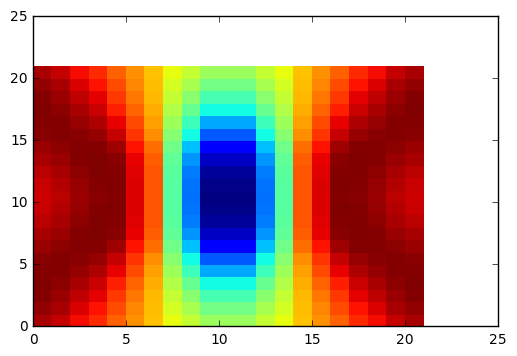

In [18]:
#plt.pcolor(Data[:,:,0].T)
plt.pcolor(Data[:,:].T)

In [19]:
u1 = problem.fields(sigma)
u2 = problem.fields(sigmahomo)

In [20]:
Msig1 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigma)))
Msig2 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigmahomo)))

In [21]:
j1 = Msig1*mesh.cellGrad*u1[txList, 'phi']
j2 = Msig2*mesh.cellGrad*u2[txList, 'phi']

In [22]:
# us = u1-u2
js = j1-j2

(-300, 0)

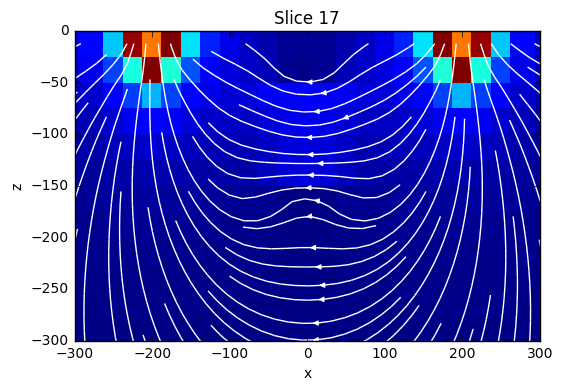

In [23]:
mesh.plotSlice(mesh.aveF2CCV*j1, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

(-300, 0)

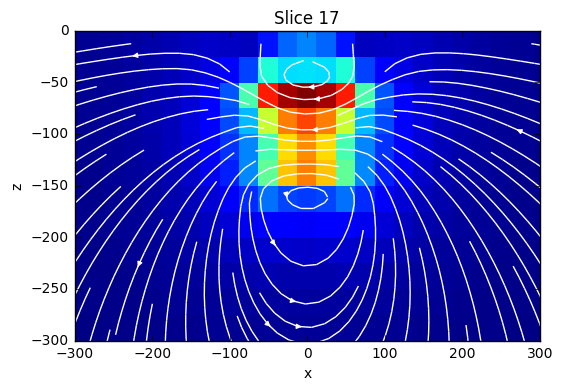

In [24]:
mesh.plotSlice(mesh.aveF2CCV*js, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

In [25]:
a = np.random.randn(3)

In [26]:
print (a.reshape([1,-1])).repeat(3, axis = 0)
print (a.reshape([1,-1])).repeat(3, axis = 0).sum(axis=1)

[[-0.03592032 -1.2996036   0.88910391]
 [-0.03592032 -1.2996036   0.88910391]
 [-0.03592032 -1.2996036   0.88910391]]
[-0.44642001 -0.44642001 -0.44642001]


In [27]:
def DChalf(txlocP, txlocN, rxloc, sigma, I=1.):
    rp = (txlocP.reshape([1,-1])).repeat(rxloc.shape[0], axis = 0)
    rn = (txlocN.reshape([1,-1])).repeat(rxloc.shape[0], axis = 0)
    rP = np.sqrt(((rxloc-rp)**2).sum(axis=1))
    rN = np.sqrt(((rxloc-rn)**2).sum(axis=1))
    return I/(sigma*2.*np.pi)*(1/rP-1/rN)

In [38]:
#data_analP = DChalf(np.r_[-200, 0, 0.],np.r_[+200, 0, 0.], xyz_rxP, sighalf)
data_analP = DChalf(np.r_[-200, 0, 0.],np.r_[+200, 0, 0.], xyz_rxM, sighalf)
data_analN = DChalf(np.r_[-200, 0, 0.],np.r_[+200, 0, 0.], xyz_rxN, sighalf)
data_anal = data_analP-data_analN

In [39]:
Data_anal = data_anal.reshape((21, 21), order = 'F')
#Data = data.reshape((21, 21,2), order = 'F')
Data = data.reshape((21, 21), order = 'F')
DataP = dataP.reshape((21,21), order = 'F')
X = xyz_rxM[:,0].reshape((21, 21), order = 'F')
Y = xyz_rxM[:,1].reshape((21, 21), order = 'F')

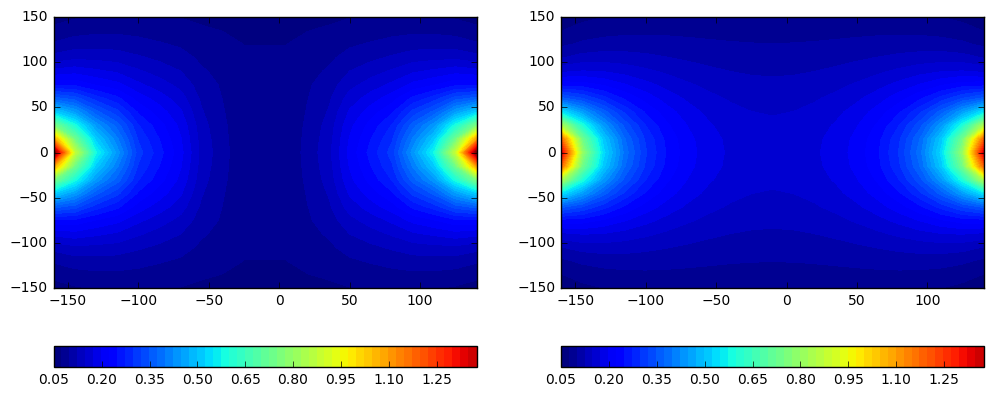

In [40]:
# plot the electric potential for 1) Numeric Solution for block in halfspace and 2) Analytic solution of halfspace
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.r_[data, data_anal].min()
vmax = np.r_[data, data_anal].max()
dat0 = ax[0].contourf(X, Y, Data[:,:], 60, vmin = vmin, vmax = vmax)
dat1 = ax[1].contourf(X, Y, Data_anal, 60, vmin = vmin, vmax = vmax)
cb0 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[0])
cb1 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[1])

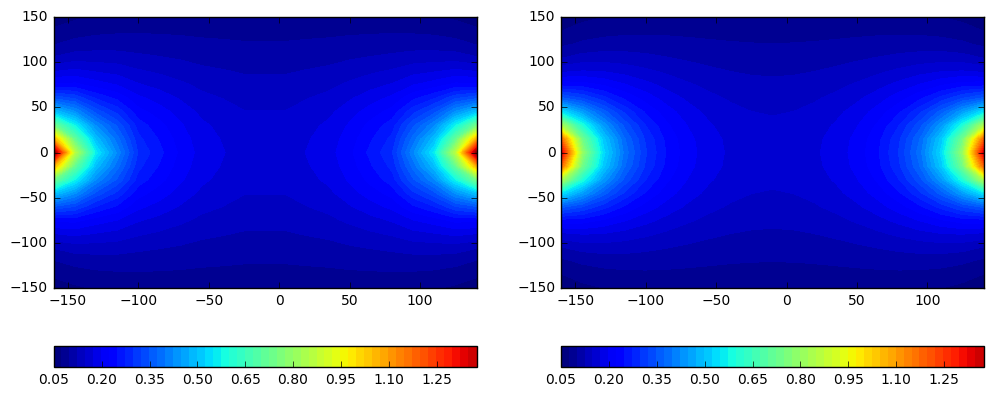

In [41]:
# plot the electric potential for 1) Numeric soln. of halfspace and 2) Analytic solution of halfspace
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.r_[data, data_anal].min()
vmax = np.r_[data, data_anal].max()
#dat0 = ax[0].contourf(X, Y, DataP[:,:], 60, vmin = vmin, vmax = vmax)
dat0 = ax[0].contourf(X,Y, DataP, 60, vmin = vmin, vmax = vmax)
dat1 = ax[1].contourf(X, Y, Data_anal, 60, vmin = vmin, vmax = vmax)
cb0 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[0])
cb1 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[1])